# Retinal Warping

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy import optimize
npa = np.array

import sys
sys.path.insert(0, '..')



In [10]:
import os
print(os.getcwd())
os.chdir()

C:\Users\julia\Documents\1A ECM\Training\projet\alternance\POLO\notebooks


The delta_lookup function simulates cone density as a function of eccentricity.

>    delta_lookup: $r \rightarrow r'$

>    $d[i] =  1 / \sqrt{\pi \cdot \rho_{fovea}} \cdot exp(a/2 * r[i]) $

>    $r'[i] = r[i-1] + d[i-1]$

where 

$r$: cone position along radial axis in input space (same as eccentricity)

$r^\prime$: cone position along radial axis in output space (can be considered as the index of cones)

$d$: distance between cones

$\rho_{fovea}$: cones density at fovea

$a: \frac{log(\text{max ratio})}{r_{max}}$

max_ratio: (cone density @ fovea) / (cone density @ periphery). This ratio equal 10 for 4 degrees of visual field in primates. 

c.f. Watson, A. B. (2016). A formula for human retinal ganglion cell receptive field density as a function of visual field location. Journal of Vision, 14(2014), 1–17. https://doi.org/10.1167/14.7.15.doi


## Determine the cone density at fovea

The value of rho_fovea needs to be tuned such that the computed r covers the entire input space.
This number depends on both input and output sizes. The retinawarp function warps the image data within the image of size "input_size" into an image of size "output_size".

`get_rf_value` function could be called to find the optimal $\rho_{fovea}$ value.

In [32]:
from retina.common import get_rf_value
# Use newton's law to find the solution instead of manual approach above.
# Last r should be equal half the in_size

in_size=440
out_size=220

optimal_rf = get_rf_value(in_size, out_size)
print('Optimal RF for input size [{0}x{0}] and output size [{1}x{1}]: {2:.2f}'.format(in_size, out_size, optimal_rf))


Optimal RF for input size [440x440] and output size [220x220]: 0.22


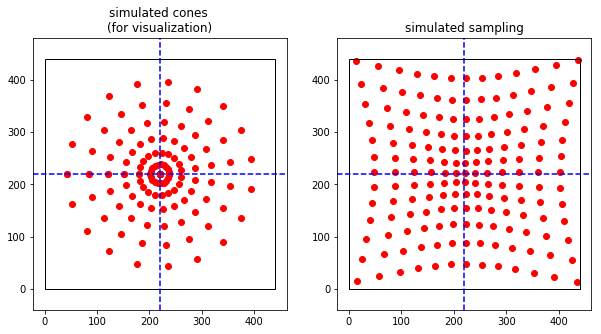

In [33]:
from retina.common import delta_lookup, fit_func

rprime, r= delta_lookup(in_size, out_size, max_ratio=10.)

# find_retina_mapping(fit_mode='quad')
func = lambda x, a, b: a * x ** 2 + b * x
retina_func = func
popt, pcov = fit_func(func, rprime, r)
retina_pars = popt

# simulated version
r_s = np.arange(out_size/2+1, step=16)
r_simulated = np.tile(r_s, (20,1)).T.flatten()
theta = np.tile(np.linspace(-np.pi, np.pi, 20), (1, len(r_s)))
r_simulated = retina_func(r_simulated, *retina_pars)
x_simulated = in_size/2. + r_simulated*np.cos(theta)
y_simulated = in_size/2. + r_simulated*np.sin(theta)

# real sampling version
#xy = warp_func(xy_out, in_size, retina_func, retina_pars, shift=None)
xy_out = np.indices((out_size, out_size))[:,::16,::16][:,1:,1:].reshape(2,-1)
xy_out = xy_out - out_size/2. 
r_out = np.linalg.norm(xy_out, axis=0)
theta = np.arctan2(xy_out[1], xy_out[0])


r = retina_func(r_out, *retina_pars)
x = in_size/2. + r*np.cos(theta)
y = in_size/2. + r*np.sin(theta)


# Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].add_patch(matplotlib.patches.Rectangle((0,0), in_size, in_size, fill=False))
ax[0].scatter(x_simulated, y_simulated, color='r')
ax[0].axvline(in_size/2., ls='--', c='b')
ax[0].axhline(in_size/2., ls='--', c='b')
ax[0].axis('equal')
ax[0].set_title('simulated cones \n(for visualization)')

ax[1].add_patch(matplotlib.patches.Rectangle((0,0), in_size, in_size, fill=False))
ax[1].scatter(x, y, color='r')
ax[1].axvline(in_size/2., ls='--', c='b')
ax[1].axhline(in_size/2., ls='--', c='b')
ax[1].axis('equal')
ax[1].set_title('simulated sampling')

plt.show()

# Retina Transform With Numpy

C:\Users\julia\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\julia\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


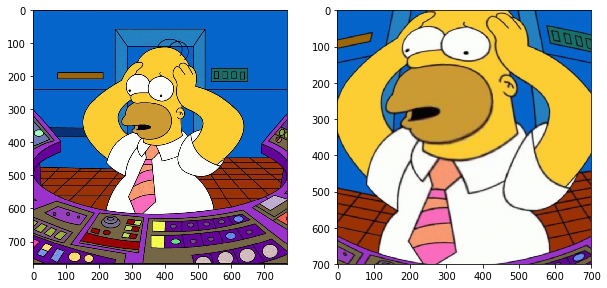

In [35]:
from retina.retina import warp_image
import imageio
from skimage.transform import resize
import matplotlib.pyplot  as plt
%matplotlib inline

RESIZE_SCALE = 0.75

img_orig = imageio.imread('../data/homer.jpg')
img = resize(img_orig, np.array(RESIZE_SCALE*npa(img_orig.shape[:2]), dtype=int))
ret_img = warp_image(img, output_size=700, input_size=350)
fig, axes = plt.subplots(ncols=2, figsize=(10,10))
axes[0].imshow(img_orig)
axes[1].imshow(ret_img)
plt.show()

# Retina Transform with Tensorflow

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from retina.retina_tf import warp_image
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

RESIZE_SCALE = .75

import tensorflow as tf

with tf.Session() as sess:
    img_orig = imageio.imread('../data/homer.jpg')
    img = resize(img_orig, RESIZE_SCALE*npa(img_orig.shape[:2]))
    retina_img = warp_image(img, output_size=700, input_size=350)
    retina_img = retina_img.eval()
fig, axes = plt.subplots(ncols=2, figsize=(10,10))
axes[0].imshow(img_orig)
axes[1].imshow(retina_img)
plt.show()

ModuleNotFoundError: No module named 'tensorflow'